In [1]:
from utils import *

import numpy as np
import pandas as pd
import lightgbm as lgb

from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
%%time
np.random.seed(0)

# first day of forecast out of 28
fcst_date = 1914
# week number to forecast (separate model for each week)
fcst_horizon = 4

sales, prices, calendar, encoder = prepare_data(fcst_date)

CPU times: user 25.6 s, sys: 6.28 s, total: 31.9 s
Wall time: 33.6 s


In [3]:
print(sales['dept_id'].unique())
print(sales['cat_id'].unique())
print(sales['state_id'].unique())

[3 4 5 6 0 1 2]
[1 2 0]
[0 1 2]


In [4]:
%%time
# reduce rows to only 1 state
print(sales.shape)
# filtered_id = sales[(sales['state_id'] == 1) & (sales['cat_id'] ==1)]['id']
# sales = sales[sales['id'].isin(filtered_id)]
sales = sales[(sales['state_id'] == 1) & (sales['cat_id'] ==1)]
print(sales.shape)

(59181090, 8)
(3289995, 8)
CPU times: user 513 ms, sys: 372 ms, total: 885 ms
Wall time: 956 ms


In [5]:
%%time
# calculated date of the first sale and add it to summary and sales

firstbuy = sales[sales['qty']!=0].groupby('id')[['date']].min()
firstbuy.rename(columns={'date':'firstbuy_date'}, inplace=True)
# if 'firstbuy_date' not in summary.columns:
#     summary = summary.join(firstbuy, on='id', how='left')
if 'firstbuy_date' not in sales.columns:
    sales = sales.join(firstbuy, on='id', how='left')
del firstbuy

CPU times: user 357 ms, sys: 26.7 ms, total: 383 ms
Wall time: 419 ms


In [6]:
%%time
# remove starting zeroes for every TS
print(sales.shape)
sales = sales[sales['date'] >= sales['firstbuy_date']]
print(sales.shape)

(3289995, 9)
(2646284, 9)
CPU times: user 129 ms, sys: 39 ms, total: 168 ms
Wall time: 167 ms


In [7]:
%%time
# sort values by id and date to add lags
sales.sort_values(['id', 'date'], inplace=True)
calendar['day'] = calendar['d'].apply(lambda x: int(x[2:])).astype('uint16')
calendar['week'] = day_to_week(calendar['day']).astype('uint16')
calendar.tail(10)

CPU times: user 957 ms, sys: 109 ms, total: 1.07 s
Wall time: 1.11 s


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day,week
1959,2016-06-10,11619,Friday,7,6,2016,d_1960,NaN,NaN,NaN,NaN,1,0,0,1960,280
1960,2016-06-11,11620,Saturday,1,6,2016,d_1961,NaN,NaN,NaN,NaN,0,1,1,1961,280
1961,2016-06-12,11620,Sunday,2,6,2016,d_1962,NaN,NaN,NaN,NaN,0,1,1,1962,280
1962,2016-06-13,11620,Monday,3,6,2016,d_1963,NaN,NaN,NaN,NaN,0,1,0,1963,281
1963,2016-06-14,11620,Tuesday,4,6,2016,d_1964,NaN,NaN,NaN,NaN,0,0,1,1964,281
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,1965,281
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,1966,281
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,1967,281
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,1968,281
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,1969,281


In [8]:
%%time
sales = sales.join(calendar[['date', 'day', 'week']].set_index('date'), on='date', how='left')
sales

CPU times: user 224 ms, sys: 25.8 ms, total: 250 ms
Wall time: 249 ms


,id,date,qty,item_id,dept_id,cat_id,store_id,state_id,firstbuy_date,day,week
27422706,14374,2013-07-16,1,1437,3,1,4,1,2013-07-16,900,129
27453196,14374,2013-07-17,3,1437,3,1,4,1,2013-07-16,901,129
27483686,14374,2013-07-18,0,1437,3,1,4,1,2013-07-16,902,129
27514176,14374,2013-07-19,0,1437,3,1,4,1,2013-07-16,903,129
27544666,14374,2013-07-20,0,1437,3,1,4,1,2013-07-16,904,129
...,...,...,...,...,...,...,...,...,...,...,...
59047498,20016,2016-05-18,0,2001,4,1,6,1,2013-05-21,1937,277
59077988,20016,2016-05-19,0,2001,4,1,6,1,2013-05-21,1938,277
59108478,20016,2016-05-20,0,2001,4,1,6,1,2013-05-21,1939,277
59138968,20016,2016-05-21,0,2001,4,1,6,1,2013-05-21,1940,277


In [9]:
%%time
# средние продажи за последнюю неделю
temp = sales[['id', 'week', 'qty']]
temp['week'] = temp['week'] + fcst_horizon
temp = temp.groupby(['id', 'week']).mean()

# add rolling mean (corresponding to month)
for window in [4, 52]:
    if window == 4:
        temp_month = temp.groupby('id').apply(lambda x: x.rolling(window, min_periods=4).mean()).reset_index()
#         temp_month = df[[ 'qty']].rolling(window, min_periods=4).mean().reset_index()
        temp_month.rename(columns = {'qty': 'qty_mean_lastmonth'}, inplace=True)
    elif window ==52:
        temp_month = temp.groupby('id').apply(lambda x: x.rolling(window, min_periods=26).agg(['mean', 'std'])).reset_index()
#         temp_month = df[[ 'qty']].rolling(window, min_periods=26).agg(['mean', 'std']).reset_index()
        columns = temp_month.columns
        new_columns = []
        for i, x in enumerate(columns):
            if x[1] != '':
                new_columns.append(f'{x[0]}_{x[1]}_lastyear')
            else:
                new_columns.append(x[0])
        temp_month.columns = new_columns
    temp_month.set_index(['id', 'week'], inplace=True)
    temp = temp.join(temp_month)
    
temp.rename(columns={'qty': 'qty_mean_lastweek'}, inplace=True)
temp['qty_mean_ratio_week_to_month'] = (temp['qty_mean_lastweek'] / temp['qty_mean_lastmonth']).fillna(0)
temp['qty_mean_ratio_week_to_year'] = (temp['qty_mean_lastweek'] / temp['qty_mean_lastyear']).fillna(0)
temp.dropna(inplace=True)
temp

<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 11.8 s, sys: 74.9 ms, total: 11.8 s
Wall time: 11.9 s


qty_mean_lastweek  qty_mean_lastmonth  qty_mean_lastyear  \
id    week                                                             
14374 161            0.000000        1.428571e-01           0.224959   
      162            0.142857        1.785714e-01           0.222222   
      163            0.285714        2.142857e-01           0.224270   
      164            0.142857        1.428571e-01           0.221726   
      165            0.285714        2.142857e-01           0.223665   
...                       ...                 ...                ...   
20016 277            0.857143        6.071429e-01           0.519231   
      278            0.000000        5.357143e-01           0.516484   
      279            0.000000        4.285714e-01           0.513736   
      280            0.000000        2.142857e-01           0.513736   
      281            0.000000        7.771561e-16           0.513736   

            qty_std_lastyear  qty_mean_lastmonth_mean_lastyear  \
id    week                                                       
14374 161           0.196296                          0.208333   
      162           0.193463                          0.207231   
      163           0.190553                          0.207483   
      164           0.188006                          0.205255   
      165           0.185380                          0.205556   
...                      ...                               ...   
20016 277           0.569344                          0.511676   
      278           0.571536                          0.514423   
      279           0.573707                          0.515797   
      280           0.573707                          0.515797   
      281           0.573707                          0.514423   

            qty_mean_lastmonth_std_lastyear  qty_mean_ratio_week_to_month  \
id    week                                                                  
14374 161                          0.104342                      0.000000   
      162                          0.102476                      0.800000   
      163                          0.100569                      1.333333   
      164                          0.099483                      1.000000   
      165                          0.097767                      1.333333   
...                                     ...                           ...   
20016 277                          0.392234                      1.411765   
      278                          0.391886                      0.000000   
      279                          0.391449                      0.000000   
      280                          0.391449                      0.000000   
      281                          0.393160                      0.000000   

            qty_mean_ratio_week_to_year  
id    week                               
14374 161                      0.000000  
      162                      0.642857  
      163                      1.273973  
      164                      0.644295  
      165                      1.277419  
...                                 ...  
20016 277                      1.650794  
      278                      0.000000  
      279                      0.000000  
      280                      0.000000  
      281                      0.000000  

[331430 rows x 8 columns]

In [10]:
%%time
# add lag features
sales = sales.join(temp, on=['id', 'week'], how='left')
sales.dropna(inplace=True)
del temp
del temp_month
sales

CPU times: user 523 ms, sys: 90.1 ms, total: 614 ms
Wall time: 616 ms


,id,date,qty,item_id,dept_id,cat_id,store_id,state_id,firstbuy_date,day,week,qty_mean_lastweek,qty_mean_lastmonth,qty_mean_lastyear,qty_std_lastyear,qty_mean_lastmonth_mean_lastyear,qty_mean_lastmonth_std_lastyear,qty_mean_ratio_week_to_month,qty_mean_ratio_week_to_year
34221976,14374,2014-02-24,1,1437,3,1,4,1,2013-07-16,1123,161,0.000000,0.142857,0.224959,0.196296,0.208333,0.104342,0.000000,0.000000
34252466,14374,2014-02-25,0,1437,3,1,4,1,2013-07-16,1124,161,0.000000,0.142857,0.224959,0.196296,0.208333,0.104342,0.000000,0.000000
34282956,14374,2014-02-26,0,1437,3,1,4,1,2013-07-16,1125,161,0.000000,0.142857,0.224959,0.196296,0.208333,0.104342,0.000000,0.000000
34313446,14374,2014-02-27,0,1437,3,1,4,1,2013-07-16,1126,161,0.000000,0.142857,0.224959,0.196296,0.208333,0.104342,0.000000,0.000000
34343936,14374,2014-02-28,0,1437,3,1,4,1,2013-07-16,1127,161,0.000000,0.142857,0.224959,0.196296,0.208333,0.104342,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59047498,20016,2016-05-18,0,2001,4,1,6,1,2013-05-21,1937,277,0.857143,0.607143,0.519231,0.569344,0.511676,0.392234,1.411765,1.650794
59077988,20016,2016-05-19,0,2001,4,1,6,1,2013-05-21,1938,277,0.857143,0.607143,0.519231,0.569344,0.511676,0.392234,1.411765,1.650794
59108478,20016,2016-05-20,0,2001,4,1,6,1,2013-05-21,1939,277,0.857143,0.607143,0.519231,0.569344,0.511676,0.392234,1.411765,1.650794
59138968,20016,2016-05-21,0,2001,4,1,6,1,2013-05-21,1940,277,0.857143,0.607143,0.519231,0.569344,0.511676,0.392234,1.411765,1.650794


In [11]:
# %%time
# add summary
# sales = sales.join(summary[[ 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id' ]].set_index('id'), on='id')
# sales

In [12]:
%%time
# add calendar
# sales = sales.join(calendar_weekly, on='date')
# sales

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


In [13]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day,week
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,2,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,3,1
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,4,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,1965,281
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,1966,281
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,1967,281
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,1968,281


In [14]:
# temp = calendar.fillna(method='backfill')
# temp = temp.join(temp.groupby(['year','event_name_1'])[['day']].max().rename(columns={'day':'maxday'}), on=['year','event_name_1'])
# temp['days_till_next_holiday'] = temp['maxday'] - temp['day']
# temp

In [15]:
# calendar[(calendar['event_name_2'].notna()) & (calendar['event_name_2'].notna())]
# calendar['event_name_cultural'] = calendar[calendar['event_type_1'] == 'Cultural']['event_name_1']

In [16]:
%%time
# разбить ивенты на отдельные колонки по типам
for event_type in calendar['event_type_1'].dropna().unique():
    event_name_bytype = []
    for index, row in calendar.iterrows():
        if row['event_type_1'] == event_type:
            event_name_bytype.append(row['event_name_1'])
        elif row['event_type_2'] == event_type:
            event_name_bytype.append(row['event_name_2'])
        else:
            event_name_bytype.append(np.nan)
    event_type = event_type.lower()
    calendar[f'event_name_{event_type}'] = event_name_bytype

calendar.fillna(method='backfill', inplace=True)
for column in ['event_name_cultural', 'event_name_sporting', 'event_name_national', 'event_name_religious']:
    calendar = calendar.join(calendar.groupby(['year', column])[['day']].max().rename(columns={'day':'maxday'}), on=['year', column])
    calendar["days_till_next_{}".format(column.split('_')[2])] = calendar['maxday'] - calendar['day']
    calendar.drop('maxday', axis=1, inplace=True)

calendar.drop(['event_name_1',  'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)

# don't forget to fill missing holidays later

calendar

CPU times: user 1.05 s, sys: 403 µs, total: 1.05 s
Wall time: 1.07 s


,date,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,day,week,event_name_sporting,event_name_cultural,event_name_national,event_name_religious,days_till_next_cultural,days_till_next_sporting,days_till_next_national,days_till_next_religious
0,2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,1,0,SuperBowl,ValentinesDay,PresidentsDay,LentStart,336,336,23.0,39.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,2,0,SuperBowl,ValentinesDay,PresidentsDay,LentStart,335,335,22.0,38.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,3,1,SuperBowl,ValentinesDay,PresidentsDay,LentStart,334,334,21.0,37.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,1,1,0,4,1,SuperBowl,ValentinesDay,PresidentsDay,LentStart,333,333,20.0,36.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,1,0,1,5,1,SuperBowl,ValentinesDay,PresidentsDay,LentStart,332,332,19.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,0,1,1,1965,281,NBAFinalsEnd,Father's day,NaN,NaN,4,4,NaN,NaN
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,0,0,0,1966,281,NBAFinalsEnd,Father's day,NaN,NaN,3,3,NaN,NaN
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,0,0,0,1967,281,NBAFinalsEnd,Father's day,NaN,NaN,2,2,NaN,NaN
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,0,0,0,1968,281,NBAFinalsEnd,Father's day,NaN,NaN,1,1,NaN,NaN


In [17]:
%%time
sales = sales.join(calendar[['day','wday', 'month', 'year', 'wm_yr_wk',
          'snap_CA', 'snap_TX', 'snap_WI', 
          'event_name_cultural', 'event_name_sporting', 
          'event_name_national', 'event_name_religious',
          'days_till_next_cultural', 'days_till_next_sporting',
          'days_till_next_national', 'days_till_next_religious']].set_index('day'), on='day')
sales

CPU times: user 333 ms, sys: 42.8 ms, total: 376 ms
Wall time: 378 ms


,id,date,qty,item_id,dept_id,cat_id,store_id,state_id,firstbuy_date,day,...,snap_TX,snap_WI,event_name_cultural,event_name_sporting,event_name_national,event_name_religious,days_till_next_cultural,days_till_next_sporting,days_till_next_national,days_till_next_religious
34221976,14374,2014-02-24,1,1437,3,1,4,1,2013-07-16,1123,...,0,0,StPatricksDay,NBAFinalsStart,MemorialDay,LentStart,21,101,91.0,9.0
34252466,14374,2014-02-25,0,1437,3,1,4,1,2013-07-16,1124,...,0,0,StPatricksDay,NBAFinalsStart,MemorialDay,LentStart,20,100,90.0,8.0
34282956,14374,2014-02-26,0,1437,3,1,4,1,2013-07-16,1125,...,0,0,StPatricksDay,NBAFinalsStart,MemorialDay,LentStart,19,99,89.0,7.0
34313446,14374,2014-02-27,0,1437,3,1,4,1,2013-07-16,1126,...,0,0,StPatricksDay,NBAFinalsStart,MemorialDay,LentStart,18,98,88.0,6.0
34343936,14374,2014-02-28,0,1437,3,1,4,1,2013-07-16,1127,...,0,0,StPatricksDay,NBAFinalsStart,MemorialDay,LentStart,17,97,87.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59047498,20016,2016-05-18,0,2001,4,1,6,1,2013-05-21,1937,...,0,0,Father's day,NBAFinalsStart,MemorialDay,Ramadan starts,32,15,12.0,20.0
59077988,20016,2016-05-19,0,2001,4,1,6,1,2013-05-21,1938,...,0,0,Father's day,NBAFinalsStart,MemorialDay,Ramadan starts,31,14,11.0,19.0
59108478,20016,2016-05-20,0,2001,4,1,6,1,2013-05-21,1939,...,0,0,Father's day,NBAFinalsStart,MemorialDay,Ramadan starts,30,13,10.0,18.0
59138968,20016,2016-05-21,0,2001,4,1,6,1,2013-05-21,1940,...,0,0,Father's day,NBAFinalsStart,MemorialDay,Ramadan starts,29,12,9.0,17.0


In [18]:
%%time
# add length of history
sales['history_length'] = (sales['date'] - sales['firstbuy_date']).dt.days
sales.drop('firstbuy_date', axis=1, inplace=True)

CPU times: user 389 ms, sys: 147 ms, total: 536 ms
Wall time: 551 ms


In [19]:
%%time
# add day number in year
sales['dayofyear'] = sales['date'].dt.dayofyear

CPU times: user 228 ms, sys: 217 µs, total: 228 ms
Wall time: 228 ms


In [20]:
%%time
# combine 3 snap columns into 1
snap_columns = [x for x in sales.columns if x.startswith('snap_')]
temp = sales[['state_id'] + snap_columns]
temp['state_id'] = encoder.decode(temp, 'state_id')
temp2 = pd.DataFrame({})
for name, dataframe in temp.groupby('state_id'):
    dataframe['snap'] = dataframe[f'snap_{name}']
    temp2 = pd.concat([temp2, dataframe[['snap']]])
sales = sales.join(temp2)
sales.drop(snap_columns, axis=1, inplace=True)
del temp
del temp2

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 1.19 s, sys: 382 ms, total: 1.58 s
Wall time: 1.58 s


In [21]:
# TBD: 
# - add prices and their derivative features
# run script will full df or maybe create features in a loop or by a function
# train and submit forecast


In [22]:
prices
# join with daily data
# calculate average price over the last month

# проверить, не отрезано ли начало истории, нужное для расчета прайс фичей

,store_id,item_id,wm_yr_wk,sell_price
368746,0,0,11101,200
368747,0,0,11102,200
368748,0,0,11103,200
368749,0,0,11104,200
368750,0,0,11105,200
...,...,...,...,...
6512550,9,3048,11617,594
6512551,9,3048,11618,594
6512552,9,3048,11619,594
6512553,9,3048,11620,594


In [23]:
%%time
columns = ['store_id', 'item_id', 'wm_yr_wk']
# sales = sales.join(prices.set_index(columns), on=columns)

CPU times: user 18 µs, sys: 4 µs, total: 22 µs
Wall time: 24.1 µs


In [24]:
%%time
# group by store, item
temp = prices.copy()
# adjust week depending on horizon
temp['wm_yr_wk'] = temp['wm_yr_wk'] + fcst_horizon
temp.set_index(['store_id', 'item_id', 'wm_yr_wk'], inplace=True)
# calculate monthly mean
temp = temp.groupby(['store_id', 'item_id']).apply(lambda x: x.rolling(4, min_periods=1).mean())

CPU times: user 56 s, sys: 895 ms, total: 56.9 s
Wall time: 57.1 s


In [25]:
temp

sell_price
store_id item_id wm_yr_wk            
0        0       11105          200.0
                 11106          200.0
                 11107          200.0
                 11108          200.0
                 11109          200.0
...                               ...
9        3048    11621          594.0
                 11622          594.0
                 11623          594.0
                 11624          594.0
                 11625          594.0

[6841121 rows x 1 columns]

In [26]:
%%time
temp.rename(columns={'sell_price':'price_mean_month'}, inplace=True)
temp['price_mean_month'] = temp['price_mean_month'].astype(int)

temp = temp.join(prices.set_index(columns), on=columns, how='left')
# calculate ratio
temp['price_mean_ratio_week_to_month'] = (temp['sell_price'] / temp['price_mean_month']).fillna(0)
temp

CPU times: user 2.21 s, sys: 852 ms, total: 3.06 s
Wall time: 3.2 s


price_mean_month  sell_price  \
store_id item_id wm_yr_wk                                 
0        0       11105                  200       200.0   
                 11106                  200       200.0   
                 11107                  200       200.0   
                 11108                  200       200.0   
                 11109                  200       200.0   
...                                     ...         ...   
9        3048    11621                  594       594.0   
                 11622                  594         NaN   
                 11623                  594         NaN   
                 11624                  594         NaN   
                 11625                  594         NaN   

                           price_mean_ratio_week_to_month  
store_id item_id wm_yr_wk                                  
0        0       11105                                1.0  
                 11106                                1.0  
                 11107                                1.0  
                 11108                                1.0  
                 11109                                1.0  
...                                                   ...  
9        3048    11621                                1.0  
                 11622                                0.0  
                 11623                                0.0  
                 11624                                0.0  
                 11625                                0.0  

[6841121 rows x 3 columns]

In [27]:
%%time
# add price features to sales
# sales.drop('sell_price', axis=1, inplace=True)
sales = sales.join(temp, on=columns)
sales

CPU times: user 1.13 s, sys: 389 ms, total: 1.52 s
Wall time: 1.52 s


,id,date,qty,item_id,dept_id,cat_id,store_id,state_id,day,week,...,days_till_next_cultural,days_till_next_sporting,days_till_next_national,days_till_next_religious,history_length,dayofyear,snap,price_mean_month,sell_price,price_mean_ratio_week_to_month
34221976,14374,2014-02-24,1,1437,3,1,4,1,1123,161,...,21,101,91.0,9.0,223,55,0,NaN,NaN,NaN
34252466,14374,2014-02-25,0,1437,3,1,4,1,1124,161,...,20,100,90.0,8.0,224,56,0,NaN,NaN,NaN
34282956,14374,2014-02-26,0,1437,3,1,4,1,1125,161,...,19,99,89.0,7.0,225,57,0,NaN,NaN,NaN
34313446,14374,2014-02-27,0,1437,3,1,4,1,1126,161,...,18,98,88.0,6.0,226,58,0,NaN,NaN,NaN
34343936,14374,2014-02-28,0,1437,3,1,4,1,1127,161,...,17,97,87.0,5.0,227,59,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59047498,20016,2016-05-18,0,2001,4,1,6,1,1937,277,...,32,15,12.0,20.0,1093,139,0,97.0,97.0,1.0
59077988,20016,2016-05-19,0,2001,4,1,6,1,1938,277,...,31,14,11.0,19.0,1094,140,0,97.0,97.0,1.0
59108478,20016,2016-05-20,0,2001,4,1,6,1,1939,277,...,30,13,10.0,18.0,1095,141,0,97.0,97.0,1.0
59138968,20016,2016-05-21,0,2001,4,1,6,1,1940,277,...,29,12,9.0,17.0,1096,142,0,97.0,97.0,1.0


In [28]:
sales.dropna(inplace=True)
sales.reset_index(drop=True, inplace=True)
sales

,id,date,qty,item_id,dept_id,cat_id,store_id,state_id,day,week,...,days_till_next_cultural,days_till_next_sporting,days_till_next_national,days_till_next_religious,history_length,dayofyear,snap,price_mean_month,sell_price,price_mean_ratio_week_to_month
0,14374,2014-03-01,1,1437,3,1,4,1,1128,161,...,16,96,86.0,4.0,228,60,1,826.0,826.0,1.0
1,14374,2014-03-02,0,1437,3,1,4,1,1129,161,...,15,95,85.0,3.0,229,61,0,826.0,826.0,1.0
2,14374,2014-03-03,0,1437,3,1,4,1,1130,162,...,14,94,84.0,2.0,230,62,1,826.0,826.0,1.0
3,14374,2014-03-04,0,1437,3,1,4,1,1131,162,...,13,93,83.0,1.0,231,63,0,826.0,826.0,1.0
4,14374,2014-03-05,0,1437,3,1,4,1,1132,162,...,12,92,82.0,0.0,232,64,1,826.0,826.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2084058,20016,2016-05-18,0,2001,4,1,6,1,1937,277,...,32,15,12.0,20.0,1093,139,0,97.0,97.0,1.0
2084059,20016,2016-05-19,0,2001,4,1,6,1,1938,277,...,31,14,11.0,19.0,1094,140,0,97.0,97.0,1.0
2084060,20016,2016-05-20,0,2001,4,1,6,1,1939,277,...,30,13,10.0,18.0,1095,141,0,97.0,97.0,1.0
2084061,20016,2016-05-21,0,2001,4,1,6,1,1940,277,...,29,12,9.0,17.0,1096,142,0,97.0,97.0,1.0


In [29]:
for column in ['event_name_cultural', 'event_name_sporting', 'event_name_national', 'event_name_religious']:
    sales[column] = encoder.encode(sales, column)

In [30]:
X = sales.drop(['id', 'date', 'qty'], axis=1)
y = sales['qty']

train_idx = sales[sales['day'] < fcst_date].index
test_idx = sales[sales['day'] >= fcst_date].index

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y[train_idx]

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=0)

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id']
cat_feats = cat_feats + ['wday', 'month']
cat_feats = cat_feats + ['event_name_cultural', 'event_name_sporting', 'event_name_national', 'event_name_religious']

train_data = lgb.Dataset(X_train, 
                                             label = y_train, 
                                             categorical_feature=cat_feats, 
                                             free_raw_data=False)
fake_valid_data = lgb.Dataset(X_val, 
                                                  label = y_val,
                                                  categorical_feature=cat_feats,
                                                 free_raw_data=False)

In [71]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 400,
    'early_stopping_rounds':20,
    'num_leaves': 64,
    "min_data_in_leaf": 100,
    'seed': 0,
    'n_jobs': 4
}

In [72]:
%%time
model = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 

/home/anton/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/anton/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/anton/.local/lib/python3.8/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[20]	valid_0's rmse: 1.53624
[40]	valid_0's rmse: 1.49011
[60]	valid_0's rmse: 1.47922
[80]	valid_0's rmse: 1.4758
[100]	valid_0's rmse: 1.47419
[120]	valid_0's rmse: 1.47337
[140]	valid_0's rmse: 1.47231
[160]	valid_0's rmse: 1.47154
[180]	valid_0's rmse: 1.47129
[200]	valid_0's rmse: 1.47078
[220]	valid_0's rmse: 1.4702
[240]	valid_0's rmse: 1.46995
[260]	valid_0's rmse: 1.46957
[280]	valid_0's rmse: 1.4698
Early stopping, best iteration is:
[275]	valid_0's rmse: 1.46947
CPU times: user 6min 26s, sys: 2.8 s, total: 6min 28s
Wall time: 1min 46s


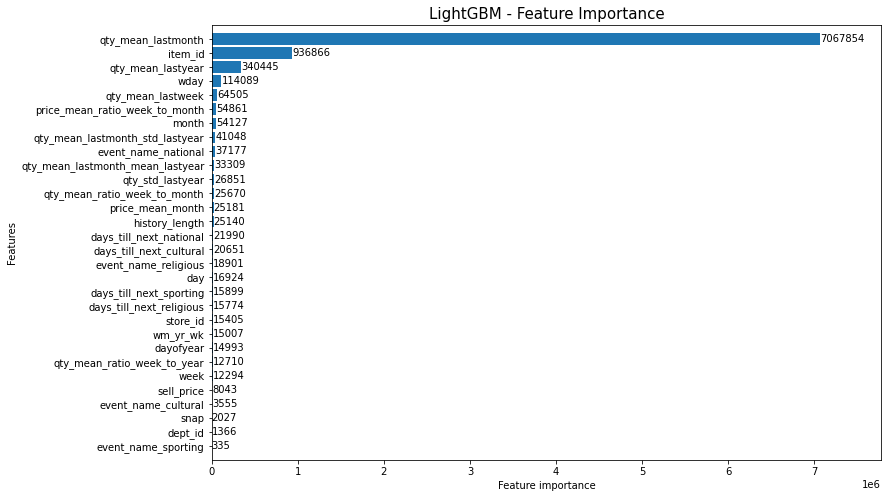

In [75]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax, importance_type='gain', precision=0)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()